# PCA Analysis

This notebook runs PCA on role vectors and examines the top PCs.

In [4]:
import sys
sys.path.insert(0, '..')

import torch
import numpy as np
from pathlib import Path
from huggingface_hub import snapshot_download
from huggingface_hub.utils import disable_progress_bars

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from assistant_axis import compute_pca, MeanScaler

disable_progress_bars()

## Configuration

In [5]:
# Model configuration
MODEL_NAME = "gemma-2-27b"
TARGET_LAYER = 22

# Local paths if you computed the vectors yourself
LOCAL_ROLE_VECTORS_DIR = Path(f"../outputs/{MODEL_NAME}/role_vectors")
LOCAL_DEFAULT_VECTOR_PATH = Path(f"../outputs/{MODEL_NAME}/default_vector.pt")

# HuggingFace configuration for pre-computed vectors
# Models supported: gemma-2-27b, qwen-3-32b, llama-3.3-70b
REPO_ID = "lu-christina/assistant-axis-vectors"

## Load Data

Run **one** of the two sections below.

In [6]:
# HuggingFace
print(f"Loading from HuggingFace: {REPO_ID}")

# Download all vectors for this model
local_dir = snapshot_download(
    repo_id=REPO_ID,
    repo_type="dataset",
    allow_patterns=[f"{MODEL_NAME}/role_vectors/*.pt", f"{MODEL_NAME}/default_vector.pt"]
)

# Load role vectors
role_vectors = {p.stem: torch.load(p, map_location="cpu", weights_only=False)
                for p in Path(local_dir, MODEL_NAME, "role_vectors").glob("*.pt")}
print(f"Loaded {len(role_vectors)} role vectors")

# Load default vector
default_vector = torch.load(Path(local_dir, MODEL_NAME, "default_vector.pt"), map_location="cpu", weights_only=False)
print(f"Default vector shape: {default_vector.shape}")

Loading from HuggingFace: lu-christina/assistant-axis-vectors


c:\Users\TZabelin\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\TZabelin\.cache\huggingface\hub\datasets--lu-christina--assistant-axis-vectors. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Loaded 275 role vectors
Default vector shape: torch.Size([46, 4608])


In [7]:
# FOR LOCAL

# print(f"Loading from local: {LOCAL_ROLE_VECTORS_DIR}")

# # Load role vectors
# role_vectors = {p.stem: torch.load(p, map_location="cpu", weights_only=False)
#                 for p in LOCAL_ROLE_VECTORS_DIR.glob("*.pt")}
# print(f"Loaded {len(role_vectors)} role vectors")

# # Load default vector
# default_vector = torch.load(LOCAL_DEFAULT_VECTOR_PATH, map_location="cpu", weights_only=False)
# print(f"Default vector shape: {default_vector.shape}")

## Run PCA

In [8]:
# Stack role vectors at target layer
role_vectors_at_layer = torch.stack([v[TARGET_LAYER] for v in role_vectors.values()]).float()
role_labels = list(role_vectors.keys())

# Run PCA with mean centering
scaler = MeanScaler()
pca_transformed, variance_explained, n_components, pca, scaler = compute_pca(
    role_vectors_at_layer,
    layer=None,
    scaler=scaler
)
print(f"Fitted PCA with {len(variance_explained)} components")

PCA fitted with 275 components
Cumulative variance for first 5 components: [0.4880164  0.5860041  0.65581596 0.7108976  0.74415094]

PCA Analysis Results:
Elbow point at component: 2
Dimensions for 70% variance: 4
Dimensions for 80% variance: 8
Dimensions for 90% variance: 18
Dimensions for 95% variance: 36
Fitted PCA with 275 components


## Plot variance explained

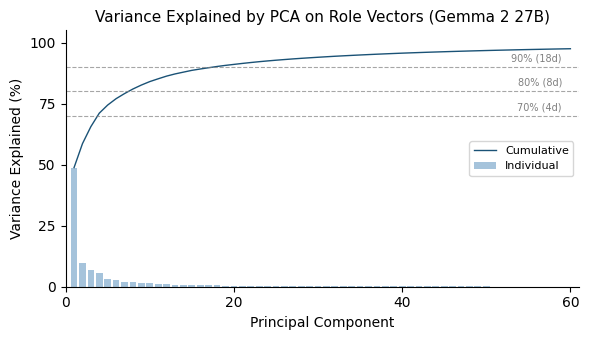

In [9]:
def plot_variance_explained(ax, variance_explained, title, max_components=60, show_ylabel=True):
    """Plot variance explained (histogram + cumulative line)."""
    n_show = min(len(variance_explained), max_components)
    var_exp = variance_explained[:n_show]
    cumulative = np.cumsum(var_exp)
    components = np.arange(1, n_show + 1)
    
    bar_color = '#6a9bc3'
    line_color = '#1a5276'
    
    ax.bar(components, var_exp * 100, width=0.8, color=bar_color, alpha=0.6, 
           edgecolor='none', label='Individual')
    ax.plot(components, cumulative * 100, color=line_color, linewidth=1, label='Cumulative')
    
    # Threshold lines at 70%, 80%, 90%
    for thresh in [70, 80, 90]:
        idx = np.argmax(cumulative >= thresh / 100.0)
        if cumulative[idx] >= thresh / 100.0:
            n_dims = idx + 1
            ax.axhline(y=thresh, color='gray', linestyle='--', linewidth=0.8, alpha=0.7)
            ax.text(max_components - 1, thresh + 1.5, f'{thresh}% ({n_dims}d)', 
                    fontsize=7, color='gray', ha='right', va='bottom')
    
    ax.set_xlim(0, max_components + 1)
    ax.set_ylim(0, 105)
    ax.set_xlabel('Principal Component')
    if show_ylabel:
        ax.set_ylabel('Variance Explained (%)')
    ax.set_title(title, fontsize=11)
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([0, 20, 40, 60])
    ax.set_yticks([0, 25, 50, 75, 100])
    ax.legend(loc='center right', fontsize=8)

fig, ax = plt.subplots(figsize=(6, 3.5))
plot_variance_explained(ax, variance_explained, f"Variance Explained by PCA on Role Vectors ({MODEL_NAME.replace('-', ' ').title()})", max_components=60)
plt.tight_layout()
plt.show()

## Cosine Similarity with Top 3 PCs

In [10]:
def plot_pc_lines(role_cosine_sims, role_labels, default_cosine_sims=None,
                       figsize=(8, 7), n_extremes=5, show_histogram=True):
    """
    Plot top 3 PCs' cosine similarities in a single figure with 3 subplots.
    
    Args:
        role_cosine_sims: (n_roles, 3) array of cosine similarities
        role_labels: List of role label names
        default_cosine_sims: Optional (3,) array of default vector cosine sims
        figsize: Figure size tuple
        n_extremes: Number of extremes to label on each end
        show_histogram: Whether to show histogram overlay
    """
    custom_cmap = LinearSegmentedColormap.from_list('PurpleTeal', ['#9b59b6', '#1abc9c'])
    
    fig, axes = plt.subplots(3, 1, figsize=figsize)
    
    for pc_idx, ax in enumerate(axes):
        projections = role_cosine_sims[:, pc_idx]
        
        # Color based on projection value
        c_norm = (projections + 1) / 2  # maps [-1, 1] to [0, 1]
        colors = custom_cmap(c_norm)
        
        # Find extreme indices
        sorted_indices = np.argsort(projections)
        low_indices = sorted_indices[:n_extremes].tolist()
        high_indices = sorted_indices[-n_extremes:][::-1].tolist()
        
        # Plot all points
        y_pos = np.zeros_like(projections)
        ax.scatter(projections, y_pos, c=colors, marker='o', s=40, alpha=0.6, edgecolors='none', zorder=3)
        
        # Histogram overlay
        if show_histogram:
            hist_counts, bin_edges = np.histogram(projections, bins=30, density=True)
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            bin_width = bin_edges[1] - bin_edges[0]
            scaled_heights = hist_counts * 0.4
            bin_norm = (bin_centers + 1) / 2
            bin_colors = custom_cmap(np.clip(bin_norm, 0, 1))
            ax.bar(bin_centers, scaled_heights, width=bin_width, alpha=0.3, color=bin_colors, edgecolor='none', zorder=1)
        
        # Add default vector marker
        if default_cosine_sims is not None:
            val = default_cosine_sims[pc_idx]
            ax.axvline(x=val, color='blue', linestyle='--', linewidth=1, alpha=0.9, zorder=2)
            ax.scatter([val], [0], c='blue', marker='*', s=300, alpha=1.0, zorder=5)
            ax.text(val, 0.55, 'Default Response', ha='center', va='bottom', fontsize=10, color='blue', alpha=0.9)
        
        # Label positions
        y_above = [0.25, 0.35, 0.45]
        y_below = [-0.25, -0.35, -0.45]
        
        # Add labels for low extremes
        for i, idx in enumerate(low_indices):
            label = role_labels[idx].replace('_', ' ').title()
            x_pos = projections[idx]
            if i % 2 == 0:
                y_label = y_above[min(i // 2, len(y_above) - 1)]
                va = 'bottom'
            else:
                y_label = y_below[min(i // 2, len(y_below) - 1)]
                va = 'top'
            line_end = y_label - 0.02 if y_label > 0 else y_label + 0.02
            ax.plot([x_pos, x_pos], [0.02 if y_label > 0 else -0.02, line_end], '-', color='gray', alpha=0.4, linewidth=0.8, zorder=1)
            ax.text(x_pos, y_label, label, ha='center', va=va, fontsize=9, zorder=4)
        
        # Add labels for high extremes
        for i, idx in enumerate(high_indices):
            label = role_labels[idx].replace('_', ' ').title()
            x_pos = projections[idx]
            if i % 2 == 0:
                y_label = y_above[min(i // 2, len(y_above) - 1)]
                va = 'bottom'
            else:
                y_label = y_below[min(i // 2, len(y_below) - 1)]
                va = 'top'
            line_end = y_label - 0.02 if y_label > 0 else y_label + 0.02
            ax.plot([x_pos, x_pos], [0.02 if y_label > 0 else -0.02, line_end], '-', color='gray', alpha=0.4, linewidth=0.8, zorder=1)
            ax.text(x_pos, y_label, label, ha='center', va=va, fontsize=9, zorder=4)
        
        # Style
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_position('zero')
        ax.axhline(y=0, color='black', linestyle='-', linewidth=2, zorder=1)
        ax.tick_params(axis='x', length=12, width=1.5, pad=10)
        ax.tick_params(axis='y', length=0, width=0)
        ax.set_yticks([])
        ax.set_xticks([-0.8, -0.4, 0, 0.4, 0.8])
        ax.set_ylim(-0.55, 0.6)
        ax.set_xlim(-1, 1)
        ax.grid(False)
        ax.set_title(f'PC{pc_idx + 1}', fontsize=12, fontweight='bold', loc='left')
    
    plt.tight_layout()
    return fig

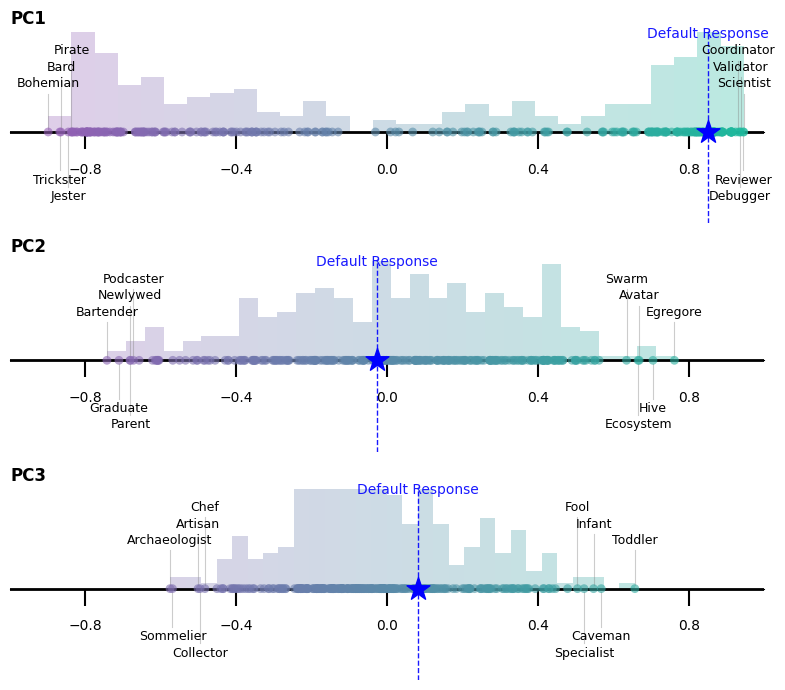

In [11]:
# Get top 3 PC directions (normalized)
pc_directions = pca.components_[:3]
pc_directions = pc_directions / np.linalg.norm(pc_directions, axis=1, keepdims=True)

# Scale and normalize role vectors
role_vectors_scaled = scaler.transform(role_vectors_at_layer.numpy())
role_vectors_norm = role_vectors_scaled / np.linalg.norm(role_vectors_scaled, axis=1, keepdims=True)

# Compute cosine similarities with PC directions: (n_roles, 3)
role_cosine_sims = role_vectors_norm @ pc_directions.T

# Scale and normalize default vector
default_at_layer = default_vector[TARGET_LAYER].float().numpy().reshape(1, -1)
default_scaled = scaler.transform(default_at_layer)
default_norm = default_scaled / np.linalg.norm(default_scaled)

# Compute default vector cosine similarities with PCs
default_cosine_sims = (default_norm @ pc_directions.T)[0]

# Plot
fig = plot_pc_lines(
    role_cosine_sims, 
    role_labels, 
    default_cosine_sims=default_cosine_sims,
    figsize=(8, 7),
    n_extremes=5,
    show_histogram=True
)
plt.show()